# Compare a few ways to generate synthetic forecasts

In this notebook we explore a few different ways to fit AR models to real data to generate synthetic observation/ensemble-hindcast data. The goal here is to come up with an approach for generating synthetic ensemble forecast data that have an appropriately similar statistical properties (along time at a given lead) to real GCM data.

In [1]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [79]:
import xarray as xr

import numpy as np

from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from src import data, utils, stats, ar_model

import warnings

warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [48]:
matplotlib.rcParams["figure.figsize"] = (14, 7)
matplotlib.rcParams["font.size"] = 12

In [4]:
DATA_DIR = "../../data/processed/"

# A) Load some SST data to play with

Here we load three different SST datasets and process them to detrended anomalies of annual means:

- **HadISST**: single member reanalysis spanning 1870  - 2021
- **HadGEM3-GC31-MM CMIP6 historical run**: four member forced historical run spanning 1850 - 2014
- **HadGEM3-GC31-MM CMIP6 DCPP runs**: ten member decadal hindcasts initialised every Nov over 1960 - 2020

In [5]:
def prep_data(ds, hindcast=False):
    """
    Some steps to prepare some data. If processing a hindcast, set
    hindcast=True
    """

    if hindcast:
        coarsen_dim = "lead"
        mean_dim = "init"
    else:
        coarsen_dim = mean_dim = "time"

    # In case time is a dask array
    ds = ds.assign_coords({"time": ds.time.compute()})

    # Annual 1-12 months
    ds = utils.get_consecutive_month_avg(ds, range(1, 13), time_dim=coarsen_dim)

    # 5x5 deg grid
    ds = data.interpolate_to_regular_grid(ds.chunk({"lat": -1, "lon": -1}), 5)

    # Anomalies
    ds = ds - ds.mean(mean_dim)

    # Detrend
    ds = utils.detrend(ds, dim=mean_dim)

    return ds.compute()

### Reanalysis data: HadISST

In [6]:
ds = prep_data(xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True))
reanalysis = ds.assign_coords({"time": ds.time.dt.year}).rename({"sst": "tos"})

### CMIP6 historical run: HadGEM3-GC31-MM

In [7]:
model = "HadGEM3-GC31-MM"

ds = prep_data(
    xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_historical.zarr", use_cftime=True),
)
historical = ds.assign_coords({"time": ds.time.dt.year})

### CMIP6 dcpp experiments: HadGEM3-GC31-MM

In [8]:
ds = prep_data(
    xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_dcpp.zarr", use_cftime=True),
    hindcast=True,
)
hindcast = ds.assign_coords(
    {"init": ds.init.dt.year, "lead": range(1, ds.sizes["lead"] + 1)}
)

### Mask the land

In [9]:
mask = (
    reanalysis["tos"].sum("time", skipna=False).notnull()
    & historical["tos"].sum(["time", "member"], skipna=False).notnull()
    & hindcast["tos"].sum(["init", "lead", "member"], skipna=False).notnull()
)

reanalysis = xr.where(mask, reanalysis, 0)
historical = xr.where(mask, historical, 0)
hindcast = xr.where(mask, hindcast, 0)

# B) Fit an AR(3) model to each dataset

We derive AR(3) coefficients in a number of different ways:

- fit, along time, the HadISST reanalysis
- fit, along time, all (four) members of the HadGEM3-GC31-MM CMIP6 historical run
- fit, along lead, all forecasts and (ten) members of the HadGEM3-GC31-MM CMIP6 DCPP runs
- fit, along lead, all forecasts and (ten) members of the HadGEM3-GC31-MM CMIP6 DCPP runs, also prepending HadISST to the beginning of each forecast

In [10]:
n_lags = 3

params = {}

params["HadISST"] = ar_model.fit(reanalysis, n_lags=n_lags)

params[f"{model}\nhistorical"] = ar_model.fit(historical, n_lags=n_lags)

params[f"{model}\nhindcast"] = ar_model.fit(hindcast, n_lags=n_lags, dim="lead")

reanalysis_init = (
    reanalysis.sel(time=hindcast.sel(lead=1).time.dt.year.values - 1)
    .rename({"time": "init"})
    .assign_coords({"lead": 0})
)
hindcast_prepend = xr.concat([reanalysis_init, hindcast.drop("time")], dim="lead")
params[f"{model}\nhindcast preprended"] = ar_model.fit(
    hindcast_prepend,
    n_lags=n_lags,
    dim="lead",
)

### How do the params compare?

The following plot shows the AR coefficients and noise term for each of the different fits

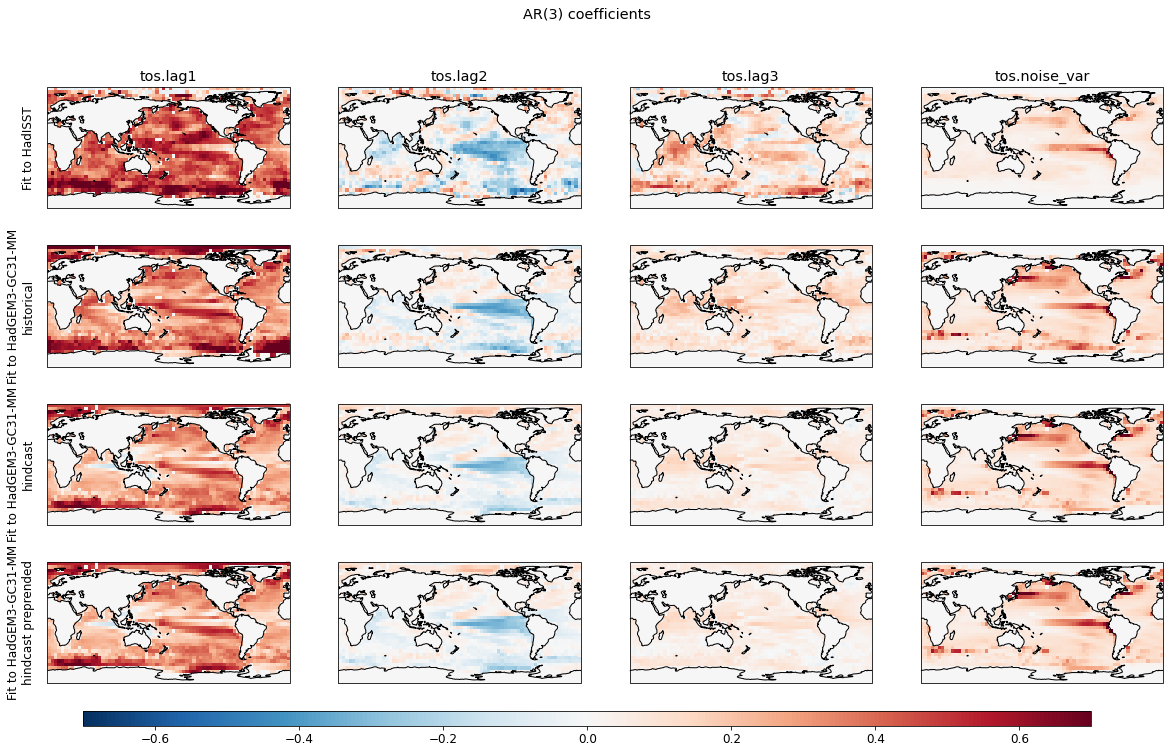

In [49]:
fig = plt.figure(figsize=(5 * (n_lags + 1), 2.6 * len(params)))
axs = fig.subplots(
    len(params),
    n_lags + 1,
    subplot_kw=dict(projection=ccrs.PlateCarree(180), sharex=True, sharey=True),
)
vrange = (-0.7, 0.7)

for idy, (name, ds) in enumerate(params.items()):
    for idx, param in enumerate(ds.params.values):
        ax = axs[idy, idx]
        p = (
            ds[list(ds.data_vars)[0]]
            .sel(params=param)
            .plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap="RdBu_r",
                add_colorbar=False,
                vmin=vrange[0],
                vmax=vrange[1],
            )
        )

        p.axes.set_global()
        p.axes.coastlines()
        ax.set_title("")
        if idx == 0:
            ax.text(
                -0.05,
                0.5,
                f"Fit to {name}",
                va="bottom",
                ha="center",
                rotation="vertical",
                rotation_mode="anchor",
                transform=ax.transAxes,
                wrap=True,
            )
        if idy == 0:
            ax.set_title(param)

fig.suptitle("AR(3) coefficients")

fig.subplots_adjust(bottom=0.07)
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])
_ = fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

# C) Generate some synthetic hindcasts
The overarching aim here is to generate independent pairs of synthetic observations and ensemble hindcasts that have similar statistical properties (distributions, ACFs) to real observations/hindcasts. 
1. The synthetic observations are simple to generate using one of our AR models (e.g. the fit to the HadISST reanalysis). We shall demonstrate this first below.
2. The current approach for generating synthetic ensemble forecasts is to run one of our AR models forward in time from a set of initial conditions. The initial condition for each $N_{member}$ ensemble member in a forecast is the same, but their trajectories differ because the noise component is different for each member. In practice, these forecasts will be initialised from a set synthetic observations generated in the same way as in 1., but independent of those synthetic observations.

## Generate some synthetic observations from the HadISST AR coefficients
We first generate some synthetic timeseries using the AR coefficients from the fit to the HadISST reanalysis. In the following we generate 100 synthetic SST timeseries at each grid cell.

In [12]:
n_samples = 100

synth_timeseries = ar_model.generate_samples(
    params["HadISST"], n_times=reanalysis.sizes["time"], n_samples=n_samples
)

### How do the ACFs for these synthetic timeseries compare to the HadISST reanalysis ACF?

Here we "assess" the synethic ACFs relative to the HadISST ACF at each grid cell by checking whether the HadISST ACF falls within 2.5-97.5% confidence bounds generated from multiple samples of the synthetic ACF. This test has a number of issues, but it will do for now.

In [13]:
def is_consistent(baseline, samples):
    """
    Return Trues where the baseline falls within confidence bounds generated
    from multiple samples
    """
    quantile_bounds = (0.025, 0.975)

    lower = samples.quantile(quantile_bounds[0], dim="sample")
    upper = samples.quantile(quantile_bounds[1], dim="sample")

    return (baseline >= lower) & (baseline <= upper)

In [14]:
reanalysis_acf = stats.acf(reanalysis, dim="time", nlags=n_lags)
synth_timeseries_acf = stats.acf(synth_timeseries, dim="time", nlags=n_lags)

consistent_ts = is_consistent(reanalysis_acf, synth_timeseries_acf).all("lag")

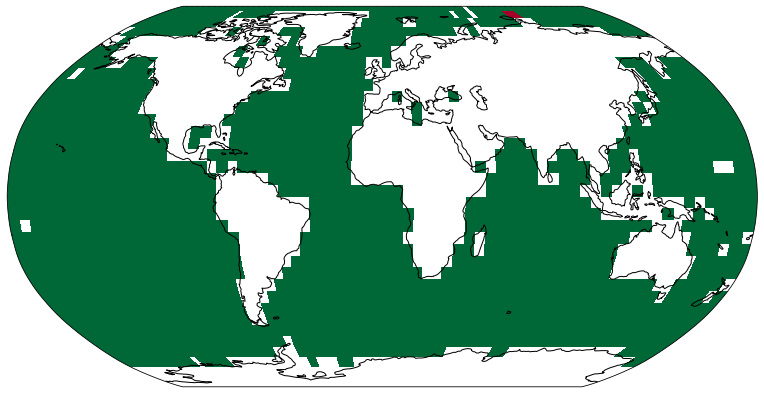

In [50]:
p = (
    consistent_ts["tos"]
    .where(mask)
    .plot(
        subplot_kws=dict(projection=ccrs.Robinson()),
        transform=ccrs.PlateCarree(),
        cmap="RdYlGn",
        add_colorbar=False,
    )
)

p.axes.set_global()
_ = p.axes.coastlines()

So, unsurprisingly, our synthethic timeseries look broadly consistent with the HadISST data.

### Now let's try to generate some synthetic hindcasts

As explained above, we generate synthetic ensemble hindcasts by running an ensemble AR model forward in time from a set of initial conditions. Here, we are looking to assess how well our synthetic hindcasts compare to real GCM hindcast. We've just seen that we can do an okay job of generating synthetic timeseries using an AR process, so we'll use these as initial conditions for our synthetic forecasts and then compare our synthetic forecasts to real GCM forecasts. In order to do this comparison, we have to be careful that our synthetic and real forecasts have the same number of initial dates and ensemble members.

Below we generate 100 sets of synthetic ensemble hindcasts using the 100 synthetic timeseries from above as initial conditions. Each ensemble hindcast has 10 members and 61 initial dates (like the HadGEM3-GC31-MM CMIP6 DCPP hindcasts). We generate synthetic hindcasts using each of the AR parameters from B.

In [ ]:
synth_hindcast = {
    name: ar_model.predict(
        param,
        synth_timeseries.isel(time=slice(hindcast.sizes["init"] + n_lags)),
        n_steps=hindcast.sizes["lead"],
        n_members=hindcast.sizes["member"],
    )
    for name, param in params.items()
}

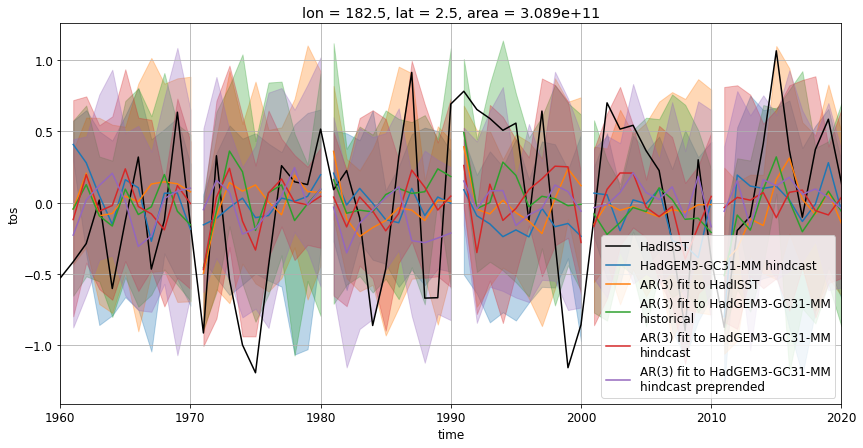

In [78]:
iloc = dict(lat=18, lon=36)
inits = range(1960, 2020, 10)

reanalysis["tos"].isel(loc).plot(color="k", label="HadISST")

colors = [f"C{i}" for i in range(len(synth_hindcast) + 1)]
colorcycler = cycle(colors)

for idx, year in enumerate(inits):
    color = next(colorcycler)
    label = f"HadGEM3-GC31-MM hindcast" if idx == 0 else "__nolabel__"
    hcst = hindcast["tos"].isel(loc).sel(init=year)
    plt.fill_between(
        year + hcst.lead,
        hcst.quantile(0.05, "member"),
        hcst.quantile(0.95, "member"),
        color=color,
        alpha=0.3,
    )
    plt.plot(year + hcst.lead, hcst.mean("member"), color=color, label=label)

    for fit, synth_hcst in synth_hindcast.items():
        color = next(colorcycler)
        label = f"AR(3) fit to {fit}" if idx == 0 else "__nolabel__"
        hcst = synth_hcst["tos"].isel(iloc).sel(init=year)
        plt.fill_between(
            year + hcst.lead,
            hcst.quantile(0.05, "member"),
            hcst.quantile(0.95, "member"),
            color=color,
            alpha=0.3,
        )
        plt.plot(year + hcst.lead, hcst.mean("member"), color=color, label=label)

plt.xlim(1960, 2020)
plt.grid()
_ = plt.legend()

### How do the ACFs **along lead time** for these synthetic hindcasts compare to real climate hindcasts?

Here we "assess" the synethic ACFs in the same way as above and we compare the ACF of the ensemble mean averaged across all inital dates

In [85]:
a = stats.acf(synth_hindcast["HadISST"].mean("member"), dim="lead", nlags=n_lags).mean(
    "init"
)

In [90]:
b = stats.acf(hindcast.mean("member"), dim="lead", nlags=n_lags).mean("init")

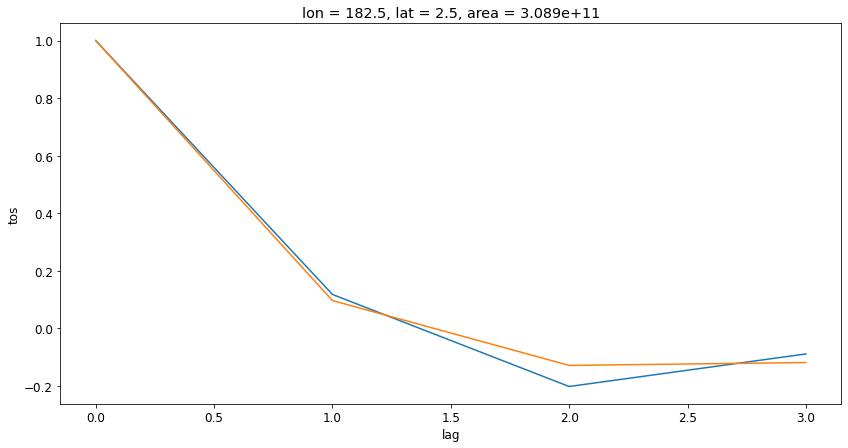

In [91]:
a.isel(iloc)["tos"].plot()
b.isel(iloc)["tos"].plot()

In [81]:
hindcast

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, init: 61, member: 10, lead: 10)
Coordinates:
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
    area     (lat, lon) float64 1.346e+10 1.346e+10 ... 1.346e+10 1.346e+10
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
  * init     (init) int64 1960 1961 1962 1963 1964 ... 2016 2017 2018 2019 2020
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10
    time     (init, lead) object 1961-12-16 00:00:00 ... 2030-12-16 00:00:00
Data variables:
    tos      (lat, lon, init, member, lead) float64 0.0 0.0 ... 0.02305 0.112

### How do the ACFs along lead time compare to those from real climate forecasts?

In [24]:
hindcast_synth["HadISST"]

<xarray.Dataset>
Dimensions:      (lat: 36, lon: 72, sample: 11, member: 10, init: 150, lead: 10)
Coordinates:
    model_order  (lat, lon) int64 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3
  * lon          (lon) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
    area         (lat, lon) float64 1.346e+10 1.346e+10 ... 1.346e+10 1.346e+10
  * sample       (sample) int64 -1 0 1 2 3 4 5 6 7 8 9
  * member       (member) int64 0 1 2 3 4 5 6 7 8 9
  * init         (init) int64 3 4 5 6 7 8 9 10 ... 146 147 148 149 150 151 152
  * lead         (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    tos          (sample, lat, lon, member, init, lead) float32 0.0 ... -0.00138

#### Generate hindcasts for each model fit

In [52]:
synthetic = {
    name: ar_model.predict(
        param, inits, n_steps=hindcast.sizes["lead"], n_members=hindcast.sizes["member"]
    )
    for name, param in params.items()
}

# Compare the synthetic ACFs to real data

In the following we compare a number of different ACFs between a number of different datasets. Our "comparison" here is to calculate the relevant ACF at each grid cell and then test whether the ACF computed using real data falls within 2.5-97.5% confidence bounds generated from multiple samples of the synthetic ACF. This test has a number of issues, but it will do for now

In [53]:
def are_acfs_consistent(baseline, simulation, n_lags, ensemble_mean=True, dim="time"):
    """
    Check whether the baseline ACFs fall within confidence bounds generated
    from multiple samples of the simulated process
    """
    quantile_bounds = (0.025, 0.975)

    if ensemble_mean:
        baseline = baseline.mean("member")
        simulation = simulation.mean("member")

    baseline_acf = stats.acf(baseline, dim=dim, nlags=n_lags)
    simulation_acf = stats.acf(simulation, dim=dim, nlags=n_lags)

    simulation_acf_lower = simulation_acf.quantile(quantile_bounds[0], dim="sample")
    simulation_acf_upper = simulation_acf.quantile(quantile_bounds[1], dim="sample")

    return (
        (baseline_acf >= simulation_acf_lower) & (baseline_acf <= simulation_acf_upper)
    ).all("lag")

### Initial condition ACFs
Compare the ACFs calculated along the **time dimension** from:
 - **synthetic initial conditions** (generated from a fit to the reanalysis)
 - **reanalysis**

In [99]:
def is_consistent(baseline, samples):
    """
    Return Trues where the baseline falls within confidence bounds generated
    from multiple samples
    """
    quantile_bounds = (0.025, 0.975)

    lower = samples.quantile(quantile_bounds[0], dim="sample")
    upper = samples.quantile(quantile_bounds[1], dim="sample")

    return (baseline >= lower) & (baseline <= upper)

In [100]:
reanalysis_acf = stats.acf(reanalysis, dim="time", nlags=n_lags)
inits_acf = stats.acf(inits.sel(sample=range(n_samples)), dim="time", nlags=n_lags)

consistent_inits = is_consistent(reanalysis_acf, inits_acf).all("lag")

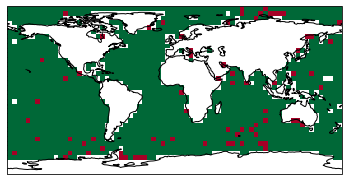

In [104]:
p = (
    consistent_inits["tos"]
    .where(mask)
    .plot(
        subplot_kws=dict(projection=ccrs.PlateCarree()),
        transform=ccrs.PlateCarree(),
        cmap="RdYlGn",
        add_colorbar=False,
    )
)

p.axes.set_global()
_ = p.axes.coastlines()

### Hindcast ACFs along lead dimensions
Compare the ACFs calculated along the **lead dimension** and averaged along the **init dimension** from:
 - **synthetic hindcasts** initialised from synthetic inits
 - **dcpp hindcasts**

In [160]:
member = 1
hindcast_init_dates = np.where(reanalysis.time.isin(hindcast.init))[0] + 1

hindcast_acf_single_mem = stats.acf(
    hindcast.sel(member=member), dim="lead", nlags=n_lags
).mean("init")
hindcast_acf_ens_mean = stats.acf(
    hindcast.mean("member"), dim="lead", nlags=n_lags
).mean("init")

consistent_hindcast_lead_single_mem = {}
consistent_hindcast_lead_ens_mean = {}
for name, synth in synthetic.items():
    # Reanalysis initialised hindcast
    synth = synth.sel(sample=range(n_samples))

    # Keep same init dates as real hindcasts
    synth = synth.sel(init=hindcast_init_dates)

    synth_acf_single_mem = stats.acf(
        synth.sel(member=member), dim="lead", nlags=n_lags
    ).mean("init")
    synth_acf_ens_mean = stats.acf(synth.mean("member"), dim="lead", nlags=n_lags).mean(
        "init"
    )

    consistent_hindcast_lead_single_mem[name] = is_consistent(
        hindcast_acf_single_mem, synth_acf_single_mem
    ).all("lag")
    consistent_hindcast_lead_ens_mean[name] = is_consistent(
        hindcast_acf_ens_mean, synth_acf_ens_mean
    ).all("lag")

### Hindcast ACFs along time dimensions
Compare the ACFs calculated along the **time dimension** from:
 - **year 1 synthetic hindcasts** initialised from synthetic inits
 - **year 1 dcpp hindcasts**